In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import skimage.registration as reg

In [2]:
import spq.ar as ar
import spq.invariants as invariants

In [3]:
# Read in a video.
vid = np.load("data/videos/wavy.npy")
print(vid.shape)

(136, 256, 256)


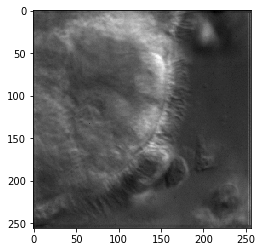

In [4]:
plt.imshow(vid[0], cmap = "gray")

In [5]:
# Compute optical flow.
import cv2

In [10]:
#cv2.calcOpticalFlowFarneback(
#  frame1,
#  frame2,
#  prevFlow,
#  pyr_scale = 0.5,
#  levels = 3 (number of pyramid levels),
#  winsize = 30 (larger = more robust but also blurrier),
#  iterations = 10 (number of iterations at each layer),
#  poly_n = 5 (larger is more robust but blurrier),
#  poly_sigma = 1.1 (size of gaussian blur),
#  flags = cv2.OPTFLOW_USE_INITIAL_FLOW & cv2.OPTFLOW_FARNEBACK_GAUSSIAN
# )

#opt = cv2.calcOpticalFlowFarneback(vid[0], vid[1], np.zeros(shape = vid[0].shape), 0.5, 3, 30, 10, 7, 1.5, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

In [6]:
def draw_flow(img, flow, step=6):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

In [7]:
from ipywidgets import interact  # Where the magic happens with ipywidgets.
from PIL import Image
from tqdm import tqdm

In [8]:
def display_video(video):
    n_frames = video.shape[0]
    
    # This is our callback function, and what makes the widget possible.
    def _show(frame = 1):
        return Image.fromarray(video[frame - 1])
    
    return interact(_show, frame = (1, n_frames))

In [9]:
flow_vid = []
rot = []

prev_flow = None
for i in tqdm(range(1, vid.shape[0])):
    curr = vid[i]
    prev = vid[i - 1]
    
    opt = cv2.calcOpticalFlowFarneback(
        prev,
        curr,
        prev_flow, 
        0.75, # pyr_scale
        7,   # levels
        15,  # winsize
        20,  # iterations
        7,   # poly_n
        0.9, # poly_sigma
        cv2.OPTFLOW_FARNEBACK_GAUSSIAN & cv2.OPTFLOW_USE_INITIAL_FLOW
    )
    opt = np.array(opt, dtype = np.float64)
    rot.append(invariants.curl(opt[:, :, 0], opt[:, :, 1]))
    flow_vid.append(draw_flow(curr, opt))
    prev_flow = opt
flow_vid = np.array(flow_vid)
rot = np.array(rot)

100%|██████████| 135/135 [00:14<00:00,  9.47it/s]


In [10]:
display_video(np.array(flow_vid[:50]))

interactive(children=(IntSlider(value=1, description='frame', max=50, min=1), Output()), _dom_classes=('widget…

<function __main__.display_video.<locals>._show(frame=1)>

In [11]:
bwrot = rot.copy()
bwrot += np.abs(bwrot.min())
bwrot /= bwrot.max()
bwrot *= 256
bwrot = np.array(bwrot, np.uint8)

In [12]:
display_video(bwrot[:100])

interactive(children=(IntSlider(value=1, description='frame', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.display_video.<locals>._show(frame=1)>

In [13]:
import scipy.signal

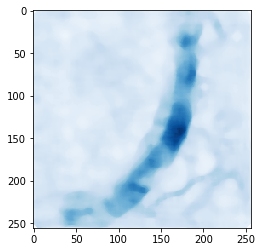

In [14]:
diff = np.abs(bwrot.max(axis = 0) - bwrot.min(axis = 0))
diff = scipy.signal.medfilt2d(diff, kernel_size = 11)
plt.imshow(diff, cmap = "Blues")

(array([4.8000e+01, 0.0000e+00, 3.0000e+00, 6.7900e+02, 2.1550e+03,
        6.1360e+03, 1.0874e+04, 9.0080e+03, 7.1610e+03, 5.5800e+03,
        5.6340e+03, 2.6640e+03, 1.6740e+03, 1.8630e+03, 1.2130e+03,
        1.4270e+03, 1.3380e+03, 6.9700e+02, 4.5300e+02, 3.9300e+02,
        5.4700e+02, 4.3000e+02, 4.8300e+02, 7.2100e+02, 4.7600e+02,
        4.1300e+02, 4.6500e+02, 3.5700e+02, 3.9400e+02, 2.5700e+02,
        3.0700e+02, 1.5000e+02, 1.5200e+02, 2.4000e+02, 1.5600e+02,
        1.4200e+02, 1.5200e+02, 7.7000e+01, 6.0000e+01, 6.5000e+01,
        6.3000e+01, 7.1000e+01, 5.2000e+01, 6.2000e+01, 6.0000e+01,
        6.1000e+01, 5.8000e+01, 2.0000e+01, 3.8000e+01, 7.0000e+00]),
 array([  0. ,   3.3,   6.6,   9.9,  13.2,  16.5,  19.8,  23.1,  26.4,
         29.7,  33. ,  36.3,  39.6,  42.9,  46.2,  49.5,  52.8,  56.1,
         59.4,  62.7,  66. ,  69.3,  72.6,  75.9,  79.2,  82.5,  85.8,
         89.1,  92.4,  95.7,  99. , 102.3, 105.6, 108.9, 112.2, 115.5,
        118.8, 122.1, 125.4, 128.7

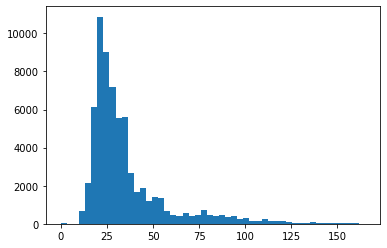

In [15]:
plt.hist(diff.flatten(), bins = 50)

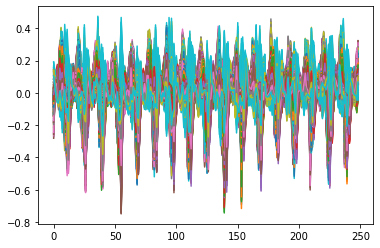

In [33]:
patch = rot[:, 125:160, 40:60]
raster = patch.reshape((patch.shape[0], -1))
plt.plot(raster)

In [16]:
import spq.ar as ar

In [17]:
order = 5

image = np.zeros(shape = (order, rot.shape[1], rot.shape[2]))
for row in tqdm(range(image.shape[1])):
    for col in range(image.shape[2]):
        a = ar.train(rot[:, row, col], order)
        image[:, row, col] = a

100%|██████████| 256/256 [00:08<00:00, 31.61it/s]


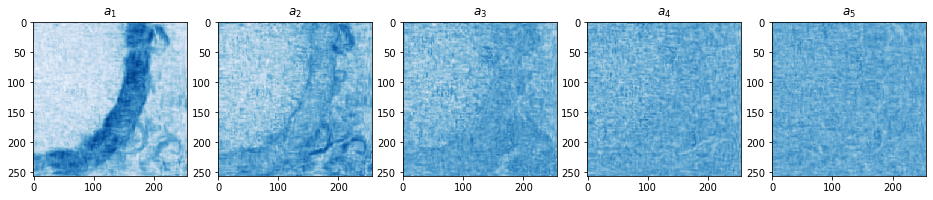

In [18]:
plt.figure(figsize = (16, 12))
for i in range(order):
    plt.subplot(1, order, i + 1)
    plt.title("$a_{}$".format(i + 1))
    plt.imshow(image[i], cmap = "Blues", vmin = image.min(), vmax = image.max())

# Let's try a different video

In [13]:
# Read in a video.
div = np.load("data/videos/stiff_dyskinetic.npy")
print(div.shape)

(250, 256, 256)


In [14]:
flow_vid = []
drot = []

prev_flow = None
for i in tqdm(range(1, div.shape[0])):
    curr = div[i]
    prev = div[i - 1]
    
    opt = cv2.calcOpticalFlowFarneback(
        prev,
        curr,
        prev_flow, 
        0.85, # pyr_scale
        7,   # levels
        15,  # winsize
        20,  # iterations
        7,   # poly_n
        0.7, # poly_sigma
        cv2.OPTFLOW_FARNEBACK_GAUSSIAN & cv2.OPTFLOW_USE_INITIAL_FLOW
    )
    opt = np.array(opt, dtype = np.float64)
    drot.append(invariants.curl(opt[:, :, 0], opt[:, :, 1]))
    flow_vid.append(draw_flow(curr, opt))
    prev_flow = opt
flow_vid = np.array(flow_vid)
drot = np.array(drot)

100%|██████████| 249/249 [00:37<00:00,  6.58it/s]


In [71]:
bwrot = drot.copy()
bwrot += np.abs(bwrot.min())
bwrot /= bwrot.max()
bwrot *= 256
bwrot = np.array(bwrot, np.uint8)

In [72]:
display_video(bwrot[:100])

interactive(children=(IntSlider(value=1, description='frame', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.display_video.<locals>._show(frame=1)>

In [15]:
dimage = np.zeros(shape = (order, drot.shape[1], drot.shape[2]))
for row in tqdm(range(dimage.shape[1])):
    for col in range(dimage.shape[2]):
        a = ar.train(drot[:, row, col], order)
        dimage[:, row, col] = a

100%|██████████| 256/256 [00:09<00:00, 27.94it/s]


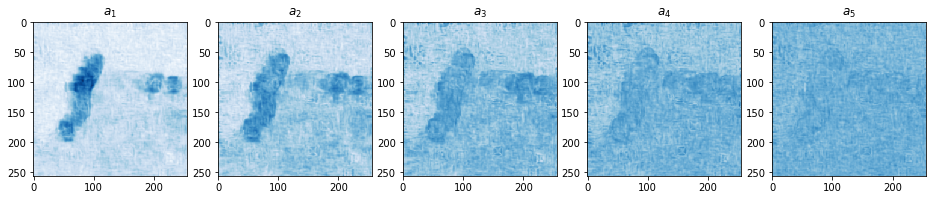

In [16]:
plt.figure(figsize = (16, 12))
for i in range(order):
    plt.subplot(1, order, i + 1)
    plt.title("$a_{}$".format(i + 1))
    plt.imshow(dimage[i], cmap = "Blues", vmin = dimage.min(), vmax = dimage.max())

In [17]:
np.save("stiff_dyskinetic_AR.npy", dimage)

In [18]:
np.save("normal_AR.npy", image)

In [19]:
np.save("wavy_AR.npy", image)